# Stitching thermal drone imagery

In [1]:
# Variable definition
imgDir = 'data/lsm/Flight 1 - Library/'
pathFile = 'data/lsm/Flight 1.csv'
utcDiff = -1
pathColumns = ['timestamp','latitude','longitude','altitude(m)','temperature(F)']
minAlt, maxAlt, altCol = 119.7, 120.3, 'altitude(m)'
imgTimes = [1619811011923,1619811099149] # Specify times if wanted
utmZone, hemisphere = '31n', 'north'
pxSize = 0.27 # pixel size (m) - for now
resolutions = [2, 6, 60]

In [2]:
# Import packages
#%pip install opencv-python
import glob
import rasterio as ro
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from tqdm import tqdm
from scipy.interpolate import griddata
from PIL import Image
from skimage.measure import block_reduce
#import cv2 as cv

In [3]:
## Retrieve images and path information
imgs = [_ for _ in glob.glob(imgDir+'*.*') if _.endswith(('.jpg','.png','.tif'))]
imgs.sort()
pathDf = pd.read_csv(pathFile)

In [5]:
## Get corresponding GPS info matched with images
# Extract date and time from filenames
imgdates = [re.search('/20(.+?)_', path).group(1) for path in imgs] # Extract date from filename
imgtimes = [re.search('_(.+?)_', path).group(1) for path in imgs] # Extract time from filename
# Convert to unix datetime 
imgdatetimes = np.array([(datetime.timestamp(datetime(int('20'+imgdates[i][:2]),int(imgdates[i][2:4]),int(imgdates[i][4:6]),int(imgtimes[i][:2])+utcDiff,int(imgtimes[i][2:4]),int(imgtimes[i][4:6])))) for i in range(len(imgs))])*1000
# Get nearest GPS timestamp
gpstimes = [min(pathDf['timestamp'], key=(lambda list_value : abs(list_value - i))) for i in imgdatetimes]
# Create image dataframe
imgDf = pd.DataFrame(data=np.array([imgs,gpstimes]).transpose(),columns=['imgPath','timestamp'])
imgDf['timestamp'] = imgDf['timestamp'].astype(float)

# Merge with path dataframe
merged = imgDf.merge(pathDf[pathColumns], on='timestamp', how='left')
# Filter for acceptable measurement altitudes
merged = merged.loc[(merged[altCol] > minAlt) & (merged[altCol] < maxAlt)]
if imgTimes: merged = merged.loc[(merged['timestamp'] > imgTimes[0]) & (merged['timestamp'] < imgTimes[1])]

# Convert coordinates to UTM
myProj = Proj('+proj=utm +zone='+utmZone+', +'+hemisphere+' +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
merged['x'], merged['y'] = myProj(merged['longitude'].values, merged['latitude'].values)

In [63]:
import shapely.geometry as sg
import geopandas as gpd
#resolutions = [pxSize,2,6,20]
#skips = [1,5,10,20]
#fig, ax = plt.subplots(len(skips),len(resolutions),figsize=[4*len(resolutions),5*len(skips)])

# Loop over resolution to create combined image for each
# for snum, skip in tqdm(enumerate(skips)):
#     print('Number of images to process: '+str(np.floor(len(merged)/skip)))
#     for num, val in enumerate(resolutions):

# Define downsample
val = 0.27
downsample = int(np.floor(val/pxSize))
imgEx = ro.open(merged.iloc[0]['imgPath'])
imgExArr = np.dstack((imgEx.read()[0],imgEx.read()[1],imgEx.read()[2]))
ds_array = imgExArr/255
rEx = block_reduce(ds_array[:, :, 0], (downsample, downsample), np.mean)

# Get x,y coordinates for each pixel
xCoords, yCoords = [(np.array(range(rEx.shape[i]))-(rEx.shape[i]/2))*val+val/2 for i in [0,1]]
xq, yq = int(np.floor(len(xCoords)/4)), int(np.floor(len(yCoords)/4))
xmCoords, ymCoords = np.meshgrid(xCoords[xq:3*xq],yCoords[yq:3*yq])
xmcr, ymcr = xmCoords.reshape(-1,1), ymCoords.reshape(-1,1)

first = True
for index, row in tqdm(merged.iterrows()):
    img = ro.open(row.imgPath)
    read = img.read()[:,xq:3*xq,yq:3*yq]
    imgArr = np.dstack((read[0],read[1],read[2]))/255
    
    if first is True:
        total = np.concatenate((xmcr+row.x, ymcr+row.y,imgArr[:,:,0].reshape(-1,1),imgArr[:,:,1].reshape(-1,1),imgArr[:,:,2].reshape(-1,1)),axis=-1)
        first=False
    else: 
        gdf = gpd.GeoDataFrame(pd.DataFrame(np.concatenate((xmcr+row.x, ymcr+row.y,imgArr[:,:,0].reshape(-1,1),imgArr[:,:,1].reshape(-1,1),imgArr[:,:,2].reshape(-1,1)),axis=-1)),geometry=gpd.points_from_xy(xmcr+row.x,ymcr+row.y))
        total = np.vstack((total, gdf[~gdf.geometry.within(poly)].values[:,:5]))
    minx, maxx, miny, maxy = min(total[:,0]), max(total[:,0]), min(total[:,1]), max(total[:,1])
    poly = sg.Polygon([[minx, miny], [maxx, miny], [maxx, maxy], [minx, maxy], [minx, miny]])
# # Loop over images
# 
# for index, row in tqdm(merged[:5].iterrows()):
#     img = ro.open(row.imgPath)
#     read = img.read()
#     imgArr = np.dstack((read[0],read[1],read[2]))
#     ds_array = imgArr/255
#     r = block_reduce(ds_array[:, :, 0], (downsample, downsample), np.mean)
#     g = block_reduce(ds_array[:, :, 1], (downsample, downsample), np.mean)
#     b = block_reduce(ds_array[:, :, 2], (downsample, downsample), np.mean)
    
    
#     total = np.vstack((total, np.concatenate((xmcr+row.x, ymcr+row.y,r.reshape(-1,1),g.reshape(-1,1),b.reshape(-1,1)),axis=-1)))

# #allDf = pd.DataFrame(total[1:],columns=['x','y','r','g','b'])  
# # Convert to grid for image
# extent = (np.ceil(min(total[1:,0])), np.floor(max(total[1:,0])),np.ceil(min(total[1:,1])),np.floor(max(total[1:,1])))
# xsGrid = np.arange(extent[0], extent[1], val)
# ysGrid = np.arange(extent[2], extent[3], val)
# xsGridm, ysGridm = np.meshgrid(xsGrid, ysGrid)

# # Associate values with grid points by interpolation - Too slow, probs need something better than this
# method = 'cubic' if val < 3 else 'nearest'
# r,g,b = [griddata(total[1:,:2], total[1:,i], (xsGridm, ysGridm), method=method) for i in [2,3,4]]

# # Plot 
# a = ax[snum,num].imshow(np.dstack((r, g, b)),extent=extent)
# if snum==0: ax[0,num].set_title('{} m resolution'.format(val))
# ax[snum,0].set_ylabel('Every {}th photo'.format(skip), size='large')
# fig.tight_layout()
#fig.savefig('plots/xystitch_allskipsNearest>3.png')

88it [01:52,  1.27s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


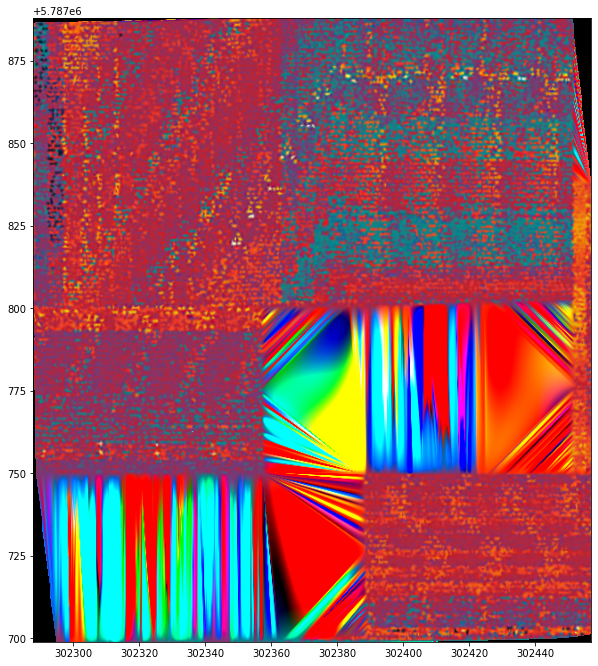

In [65]:
allDf = pd.DataFrame(total,columns=['x','y','r','g','b'])  
# Convert to grid for image
extent = (np.ceil(min(total[:,0])), np.floor(max(total[:,0])),np.ceil(min(total[:,1])),np.floor(max(total[:,1])))
xsGrid = np.arange(extent[0], extent[1], val)
ysGrid = np.arange(extent[2], extent[3], val)
xsGridm, ysGridm = np.meshgrid(xsGrid, ysGrid)

# Associate values with grid points by interpolation - Too slow, probs need something better than this
method = 'cubic' if val < 3 else 'nearest'
r,g,b = [griddata(total[1:,:2], total[1:,i], (xsGridm, ysGridm), method=method) for i in [2,3,4]]

# Plot 
fig, ax = plt.subplots(1,1,figsize=[10,15])
a = ax.imshow(np.dstack((r, g, b)),extent=extent)
# if snum==0: ax[0,num].set_title('{} m resolution'.format(val))
# ax[snum,0].set_ylabel('Every {}th photo'.format(skip), size='large')
# fig.tight_layout()

In [66]:
fig.savefig('plots/imageCentreAddition.jpg')

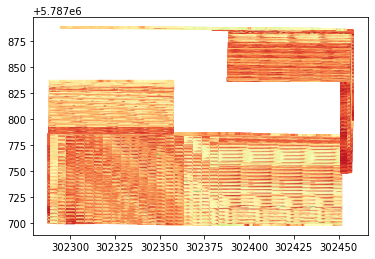

In [69]:
plt.scatter(total[:,0][::1],total[:,1][::1], c=total[:,4][::1], cmap='RdYlGn',s=1)